In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Coursework 2 of COMP0051

## 1. Time Series Prep[30 Points]


1. Download SPTL ETF at end-of-day prices for the period of time between 1
Jan 2014 to 31 December 2019. Download the Effective Fed Funds Rate (EFFR
Index) as the risk-free rate. Adjust annual risk-free rate to make it a daily rate, i.e.,
$r^f_t = EFFR(t) \cdot dc$ 
, where $dc$ is a day-count. $\newline$
You can use $dc ≈ (1/252)$.
A unit of SPTL will cost $p_t$ at time $t$, which we have to ﬁnance at the risk-free rate.\\
The daily excess return per unit of SPTL reads,
$$r_t^e = \frac{\Delta p_t}{p_t} - r_t^f$$

In [2]:
start_date = '2014-01-01'
# end_date = '2019-12-31'
end_date = '2020-01-01'  # for sptl can go to 2019-12-31

# Download SPTL at end of day
sptl = yf.download('SPTL', start=start_date, end=end_date, interval='1d')
print(sptl.head())
print("length of sptl:", len(sptl))

# Read EFFR.xlsx
effr = pd.read_excel('EFFR.xlsx')[['Effective Date', 'Rate (%)']].set_index('Effective Date')
effr.index = pd.to_datetime(effr.index)
effr = effr.sort_index()
effr['Rate (%)'] = effr['Rate (%)']
print(effr.head())
print("length of effr:", len(effr))

[*********************100%%**********************]  1 of 1 completed


                 Open       High        Low   Close  Adj Close  Volume
Date                                                                  
2014-01-02  29.924999  30.070000  29.924999  30.055  23.299047   25400
2014-01-03  29.959999  30.105000  29.959999  30.035  23.283543   22000
2014-01-06  30.110001  30.270000  30.110001  30.160  23.380442    3200
2014-01-07  30.240000  30.260000  30.200001  30.260  23.457979    3800
2014-01-08  30.075001  30.184999  30.075001  30.150  23.372698   14800
length of sptl: 1510


/Users/mohanren/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                Rate (%)
Effective Date          
2014-01-02         0.120
2014-01-03         0.120
2014-01-06         0.120
2014-01-07         0.105
2014-01-08         0.105
length of effr: 1507


In [3]:
# print the date that is different between sptl and effr
print("The date that is different between sptl and effr:")
print(sptl.index.difference(effr.index))
print(effr.index.difference(sptl.index))

The date that is different between sptl and effr:
DatetimeIndex(['2014-10-13', '2014-11-11', '2015-10-12', '2015-11-11',
               '2016-10-10', '2016-11-11', '2017-10-09', '2018-10-08',
               '2018-11-12', '2019-10-14', '2019-11-11'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2014-04-18', '2015-04-03', '2015-07-03', '2016-03-25',
               '2017-04-14', '2018-03-30', '2018-12-05', '2019-04-19'],
              dtype='datetime64[ns]', freq=None)


In [4]:
# Merge sptl and effr
df = pd.merge(sptl, effr, left_index=True, right_index=True, how='left')

# Drop columns of Open, High, Low, Close
df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Fill NaN for all columns
df = df.fillna(method='ffill')
print(df.head())
print("length of df:", len(df))

            Adj Close  Rate (%)
Date                           
2014-01-02  23.299047     0.120
2014-01-03  23.283543     0.120
2014-01-06  23.380442     0.120
2014-01-07  23.457979     0.105
2014-01-08  23.372698     0.105
length of df: 1510


In [5]:
# Calculate the daily rate
df['Daily Rate'] = df['Rate (%)'] / 252
print(df.head())

            Adj Close  Rate (%)  Daily Rate
Date                                       
2014-01-02  23.299047     0.120    0.000476
2014-01-03  23.283543     0.120    0.000476
2014-01-06  23.380442     0.120    0.000476
2014-01-07  23.457979     0.105    0.000417
2014-01-08  23.372698     0.105    0.000417


In [6]:
# remove warning
pd.options.mode.chained_assignment = None  # default='warn'

def calculate_daily_rate(df):
    # Calculate the daily excess return of SPTL
    df['Return'] = df['Adj Close'] - df['Adj Close'].shift(1)

    # Calculate the daily excess return per unit of SPTL
    df['Return/Unit'] = df['Return'] / df['Adj Close'] - df['Daily Rate'] / 100
    return df

# split the data into training and testing
split_index = int(len(df) * 0.7)
train = df.iloc[:split_index]
test = df.iloc[split_index:]
print("length of train:", len(train))
print("length of test:", len(test))

# Calculate the daily rate for train and test
train = calculate_daily_rate(train)
test = calculate_daily_rate(test)

length of train: 1057
length of test: 453


In [7]:
test.tail()

,Adj Close,Rate (%),Daily Rate,Return,Return/Unit
Date,,,,,
2019-12-24,35.660114,2.325,0.009226,0.117981,0.003216
2019-12-26,35.750870,2.325,0.009226,0.090755,0.002446
2019-12-27,35.778099,2.325,0.009226,0.027229,0.000669
2019-12-30,35.678268,2.325,0.009226,-0.099831,-0.002890
2019-12-31,35.278915,2.325,0.009226,-0.399353,-0.011412


2. Plot the SPTL return time series, the EFFR, and the excess return per unit of SPTL, starting from $t = 0$ corresponding to 1 Jan 2014.

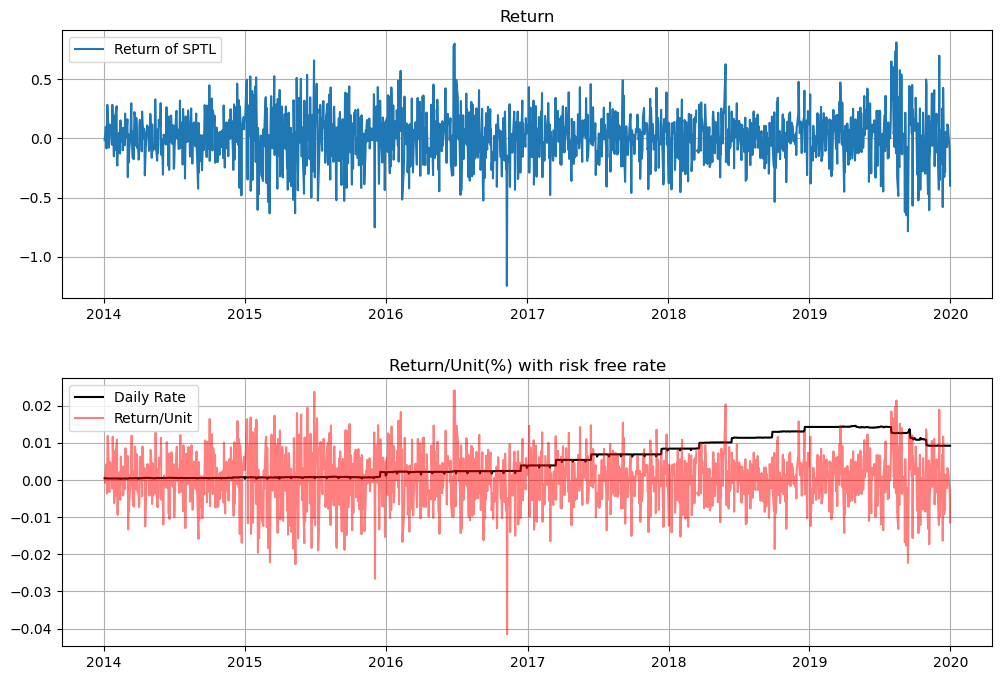

In [8]:
# merge train and test
df = pd.concat([train, test])

# plot in 3*1 subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# set gap between subplots
plt.subplots_adjust(hspace=0.3)
ax[0].plot(df['Return'], label='Return of SPTL')
ax[0].ylabel = 'Return(USD)'
ax[0].set_title('Return')
ax[0].grid()
ax[0].legend()

ax[1].plot(df['Daily Rate'], label='Daily Rate', color='black')
# ax[1].plot(df['Return'] / df['Adj Close'], label='Vanilla Return/Unit', alpha=0.3, color='pink')
ax[1].plot(df['Return/Unit'], label='Return/Unit', alpha=0.5, color='red')
ax[1].ylabel = '(%)'
ax[1].set_title('Return/Unit(%) with risk free rate')
ax[1].grid()
ax[1].legend()

plt.show()

# plot the return, the Rate, and the Return/Unit
# plt.plot(df['Return'], label='Return')
# plt.plot(df['Rate (%)'], label='Rate')
# plt.plot(df['Daily Rate'], label='Daily Rate')
# plt.plot(df['Return'] / df['Adj Close'], label='Vanilla Return/Unit')
# plt.plot(df['Return/Unit'], label='Return/Unit')
# plt.legend()
# plt.show()

## 2. Trading Strategies [45 Points] 

**Definition.** In a leveraged strategy, the (leveraged) book size is the available capital times
the leverage amount. By a leveraged strategy we mean a sequence $\{θ_t\}^T_{t=1}$ of dollar values
of SPTL which can be long or short such that
$$|\theta| \leqq V_0 \cdot L$$
where $V_0$ is the initial capital, and $L$ is the leverage.

1. 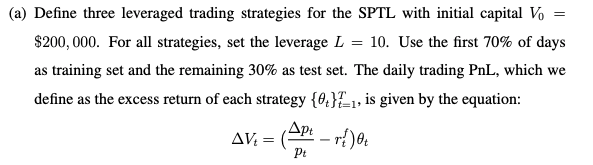

### Train-Test Split

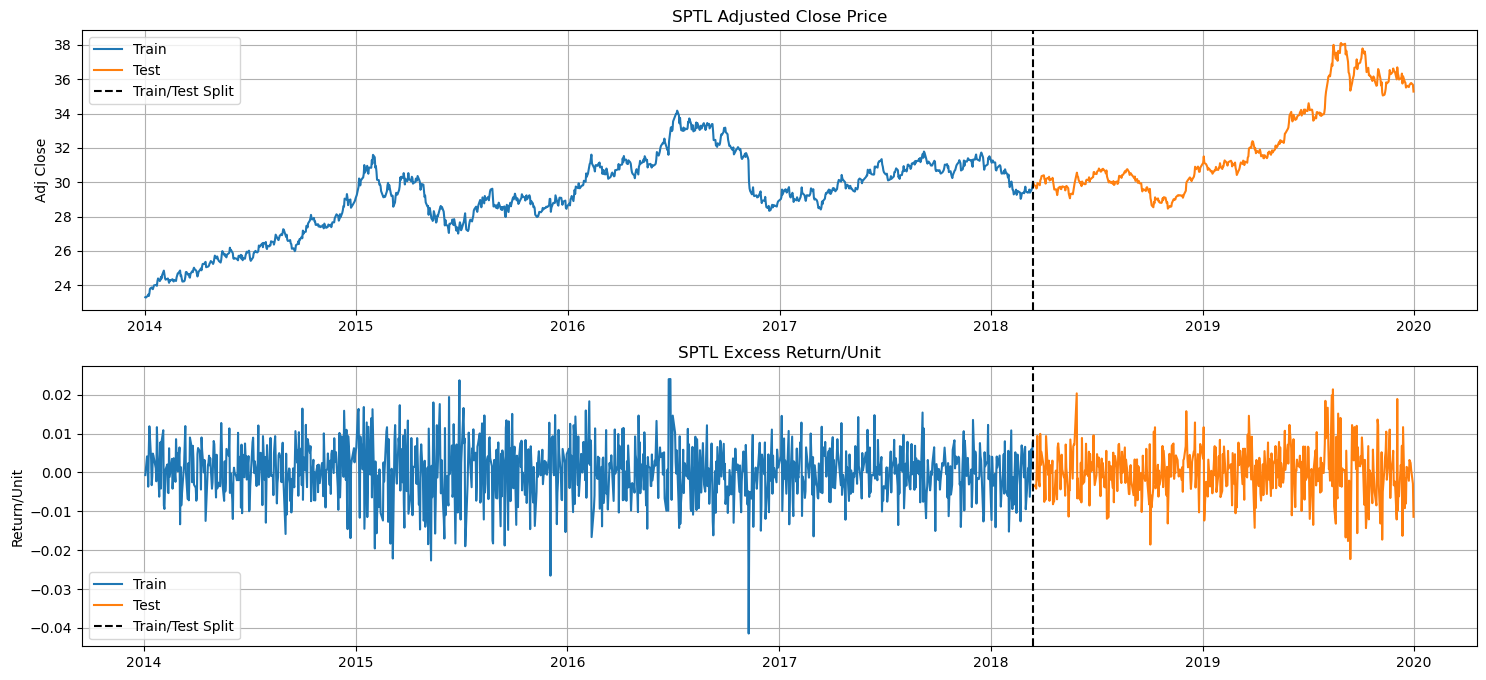

In [9]:
# Plot the price and return/unit of SPTL in two seperate subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8))
ax1.grid()
ax1.plot(train['Adj Close'], label='Train')
ax1.plot(test['Adj Close'], label='Test')
ax1.axvline(x=train.index[-1], color='k', linestyle='--', label='Train/Test Split')
ax1.set_ylabel('Adj Close')
ax1.title.set_text('SPTL Adjusted Close Price')
ax1.legend()
ax2.grid()
ax2.plot(train['Return/Unit'], label='Train')
ax2.plot(test['Return/Unit'], label='Test')
ax2.axvline(x=train.index[-1], color='k', linestyle='--', label='Train/Test Split')
ax2.set_ylabel('Return/Unit')
ax2.title.set_text('SPTL Excess Return/Unit')
ax2.legend()
plt.show()

### Define trading strategies 


In [10]:
from Strategies import buy_and_hold as bh
from Strategies import moving_average as ma
from Strategies import mean_reversion as mr

# Define parameters
V_0 = 200000  # initial capital
L = 10  # leverage

# Define the strategy of buy and hold
bh_train = bh.BuyAndHold(train, V_0, L)
bh_train.run()
bh_test = bh.BuyAndHold(test, V_0, L)
bh_test.run()

# Define the strategy of moving average momentum
best_return = float('-inf')
short_windows = [1, 5, 10, 20]
long_windows = [5, 20, 40, 60]
best_short_window = 0
best_long_window = 0
for short_window in short_windows:
    for long_window in long_windows:
        ma_train = ma.MovingAverage(train, V_0, L, short_window, long_window)
        ma_train.run()
        if ma_train.get_cumulative_PnL()[-1] > best_return:
            best_return = ma_train.get_cumulative_PnL()[-1]
            best_short_window = short_window
            best_long_window = long_window

ma_train = ma.MovingAverage(train, V_0, L, 5, 20)
ma_train.run()
ma_test = ma.MovingAverage(test, V_0, L, best_short_window, best_long_window)
ma_test.run()
print("Best short window: {}; Best long window: {}; Best return: {}".format(best_short_window, best_long_window, best_return))

# Define the strategy of mean reversion
best_return = float('-inf')
windows = [5, 10, 20, 40]
best_window = 0
for window in windows:
    mr_train = mr.MeanReversion(train, V_0, L, window)
    mr_train.run()
    if mr_train.get_cumulative_PnL()[-1] > best_return:
        best_return = mr_train.get_cumulative_PnL()[-1]
        best_window = window

mr_train = mr.MeanReversion(train, V_0, L, best_window)
mr_train.run()
mr_test = mr.MeanReversion(test, V_0, L, best_window)
mr_test.run()
print("Best window: {}; Best return: {}".format(best_window, best_return))



Best short window: 10; Best long window: 5; Best return: 1538871.1827822009
Best window: 10; Best return: 1594954.7487165255


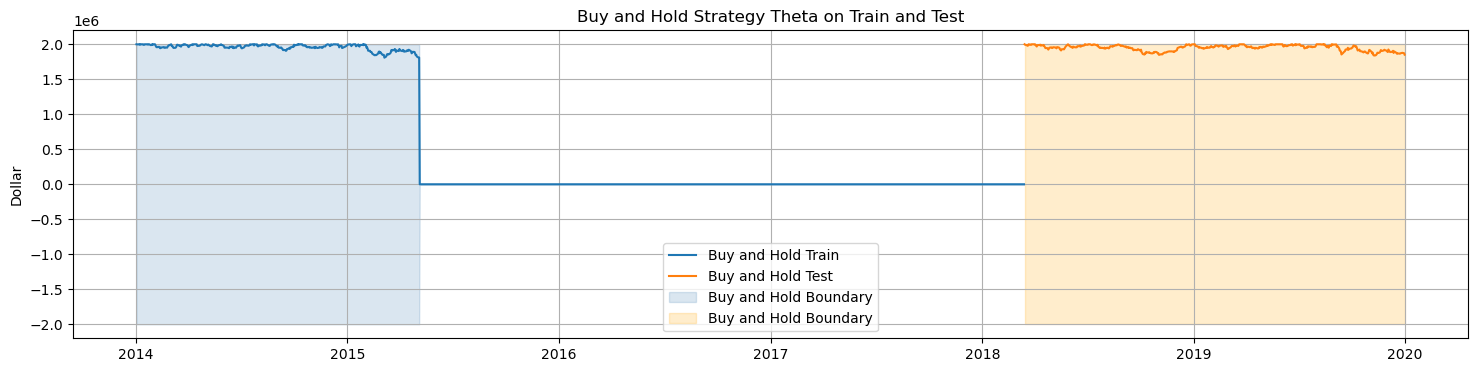

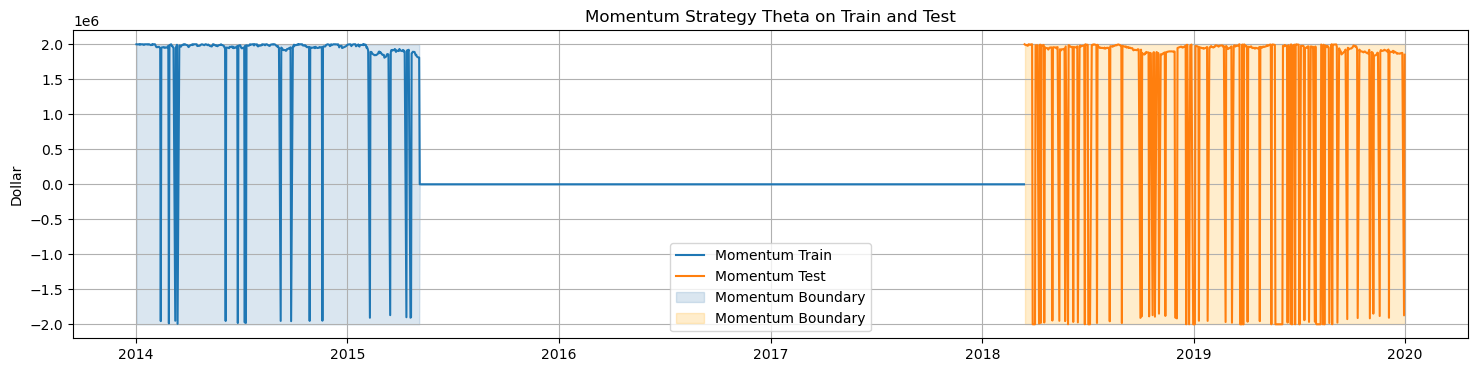

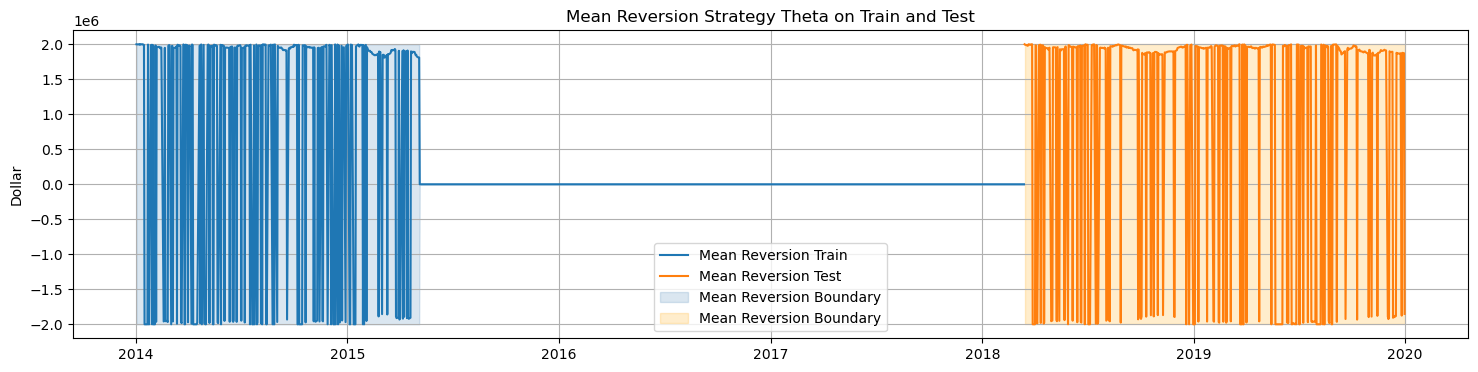

In [11]:
plt.figure(figsize=(18, 4))
plt.plot(bh_train.get_theta(), label='Buy and Hold Train')
plt.plot(bh_test.get_theta(), label='Buy and Hold Test')

upper_train = np.where(bh_train.get_theta().values != 0, V_0*L, 0)
lower_train = np.where(bh_train.get_theta().values != 0, -V_0*L, 0)

upper_test = np.where(bh_test.get_theta().values != 0, V_0*L, 0)
lower_test = np.where(bh_test.get_theta().values != 0, -V_0*L, 0)

plt.fill_between(bh_train.get_theta().index, upper_train, lower_train, color='steelblue', alpha=0.2, label='Buy and Hold Boundary')
plt.fill_between(bh_test.get_theta().index, upper_test, lower_test, color='orange', alpha=0.2, label='Buy and Hold Boundary')
plt.title('Buy and Hold Strategy Theta on Train and Test')
plt.grid()
plt.ylabel('Dollar')
plt.legend(loc='lower center')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(ma_train.get_theta(), label='Momentum Train')
plt.plot(ma_test.get_theta(), label='Momentum Test')

upper_train = np.where(ma_train.get_theta().values != 0, V_0*L, 0)
lower_train = np.where(ma_train.get_theta().values != 0, -V_0*L, 0)

upper_test = np.where(ma_test.get_theta().values != 0, V_0*L, 0)
lower_test = np.where(ma_test.get_theta().values != 0, -V_0*L, 0)

plt.fill_between(ma_train.get_theta().index, upper_train, lower_train, color='steelblue', alpha=0.2, label='Momentum Boundary')
plt.fill_between(ma_test.get_theta().index, upper_test, lower_test, color='orange', alpha=0.2, label='Momentum Boundary')
plt.title('Momentum Strategy Theta on Train and Test')
plt.grid()
plt.ylabel('Dollar')
plt.legend(loc='lower center')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(mr_train.get_theta(), label='Mean Reversion Train')
plt.plot(mr_test.get_theta(), label='Mean Reversion Test')

upper_train = np.where(mr_train.get_theta().values != 0, V_0*L, 0)
lower_train = np.where(mr_train.get_theta().values != 0, -V_0*L, 0)

upper_test = np.where(mr_test.get_theta().values != 0, V_0*L, 0)
lower_test = np.where(mr_test.get_theta().values != 0, -V_0*L, 0)

plt.fill_between(mr_train.get_theta().index, upper_train, lower_train, color='steelblue', alpha=0.2, label='Mean Reversion Boundary')
plt.fill_between(mr_test.get_theta().index, upper_test, lower_test, color='orange', alpha=0.2, label='Mean Reversion Boundary')
plt.title('Mean Reversion Strategy Theta on Train and Test')
plt.grid()
plt.ylabel('Dollar')
plt.legend(loc='lower center')
plt.show()



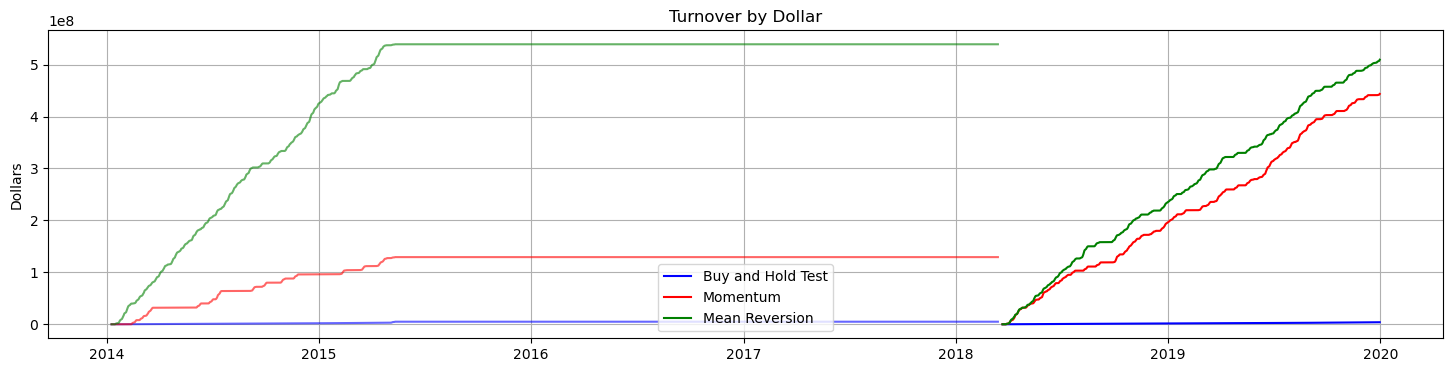

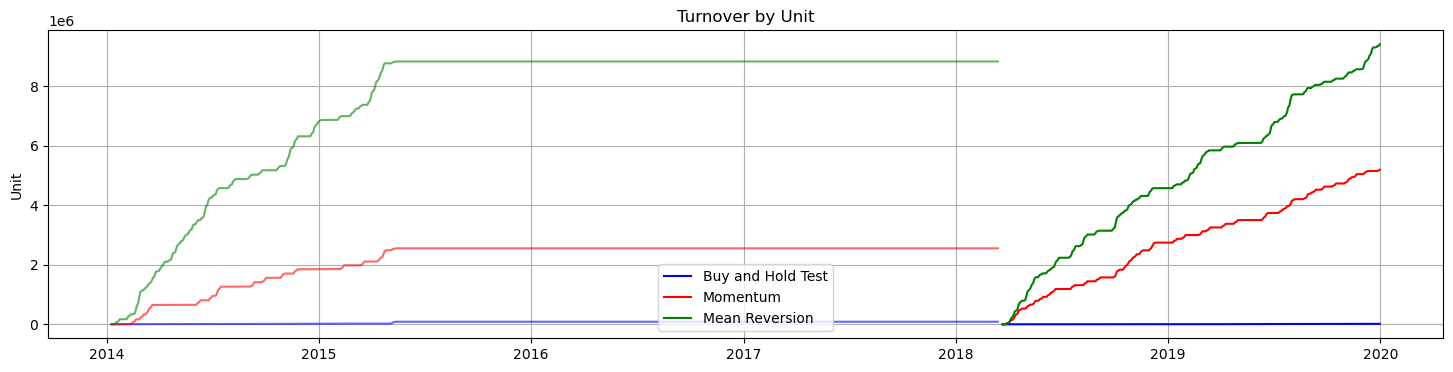

In [12]:
plt.figure(figsize=(18, 4))

# plot the moving average of the turnover dollars
plt.plot(bh_train.get_turnover_dollars().rolling(5).mean(), color='b', alpha=0.6)
plt.plot(bh_test.get_turnover_dollars().rolling(5).mean(), label='Buy and Hold Test', color='b')

plt.plot(ma_train.get_turnover_dollars().rolling(5).mean(), color='r', alpha=0.6)
plt.plot(ma_test.get_turnover_dollars().rolling(5).mean(), label='Momentum', color='r')

plt.plot(mr_train.get_turnover_dollars().rolling(5).mean(), color='g', alpha=0.6)
plt.plot(mr_test.get_turnover_dollars().rolling(5).mean(), label='Mean Reversion', color='g')

# set y label
plt.ylabel('Dollars')
# plt.yscale('log')
plt.title('Turnover by Dollar')
plt.legend(loc='lower center')
plt.grid()
plt.show()

plt.figure(figsize=(18, 4))

# plot the moving average of the turnover units
plt.plot(bh_train.get_turnover_unit().rolling(5).mean(), color='b', alpha=0.6)
plt.plot(bh_test.get_turnover_unit().rolling(5).mean(), label='Buy and Hold Test', color='b')

plt.plot(ma_train.get_turnover_unit().rolling(5).mean(), color='r', alpha=0.6)
plt.plot(ma_test.get_turnover_unit().rolling(5).mean(), label='Momentum', color='r')

plt.plot(mr_train.get_turnover_unit().rolling(5).mean(), color='g', alpha=0.6)
plt.plot(mr_test.get_turnover_unit().rolling(5).mean(), label='Mean Reversion', color='g')


# set y label
plt.ylabel('Unit')
# plt.yscale('log')
plt.title('Turnover by Unit')
plt.legend(loc='lower center')
plt.grid()
plt.show()


plt.plot(ma_train.get_stock_hold)

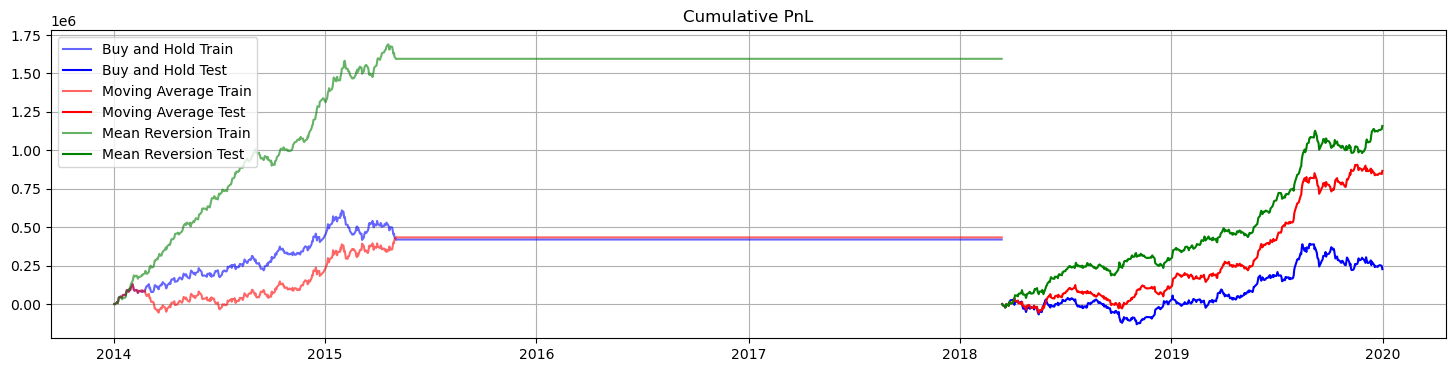

In [13]:
# Plot the cumulative PnL of the three strategies
plt.figure(figsize=(18, 4))
plt.plot(bh_train.get_cumulative_PnL(), label='Buy and Hold Train', color='b', alpha=0.6)
plt.plot(bh_test.get_cumulative_PnL() , label='Buy and Hold Test', color='b')

plt.plot(ma_train.get_cumulative_PnL(), label='Moving Average Train', color='r', alpha=0.6)
plt.plot(ma_test.get_cumulative_PnL(), label='Moving Average Test', color='r')

plt.plot(mr_train.get_cumulative_PnL(), label='Mean Reversion Train', color='g', alpha=0.6)
plt.plot(mr_test.get_cumulative_PnL(), label='Mean Reversion Test', color='g')
plt.title('Cumulative PnL')
# plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

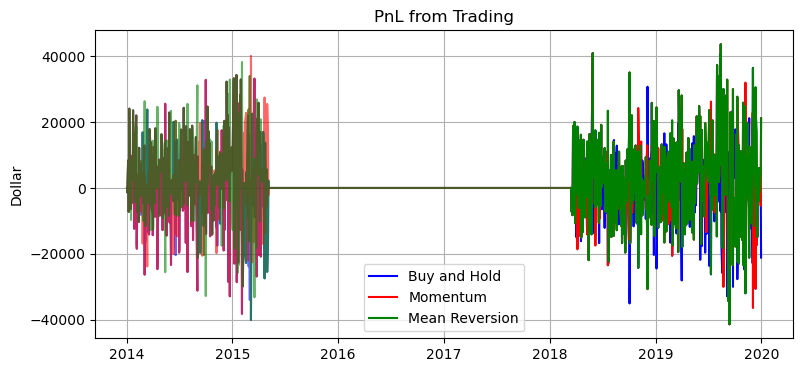

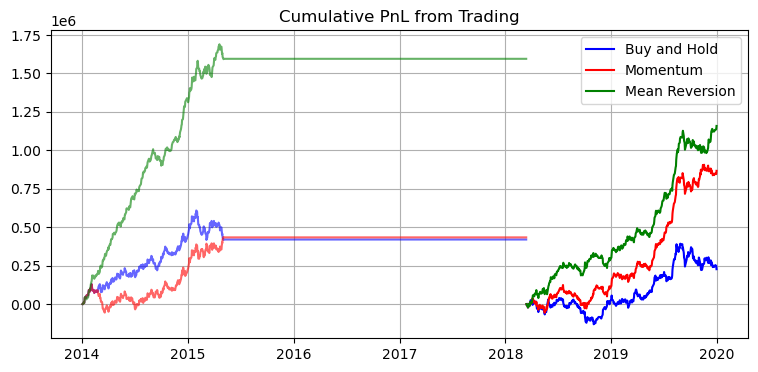

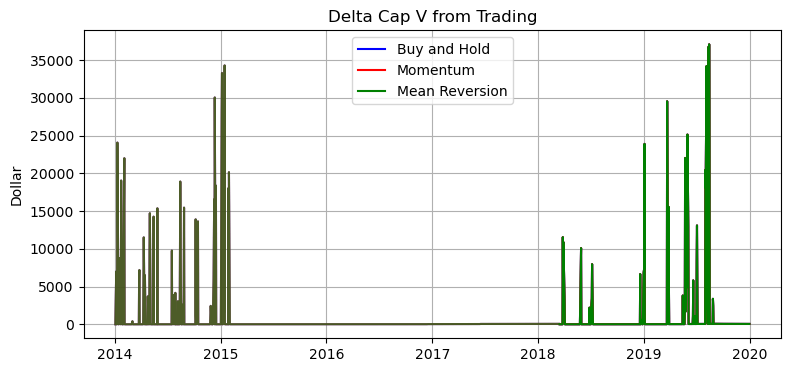

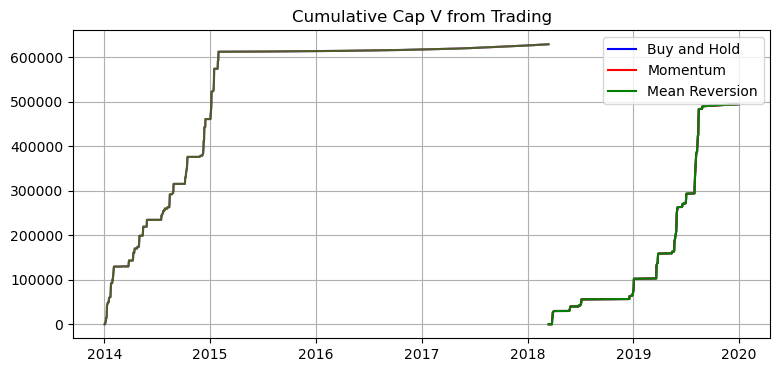

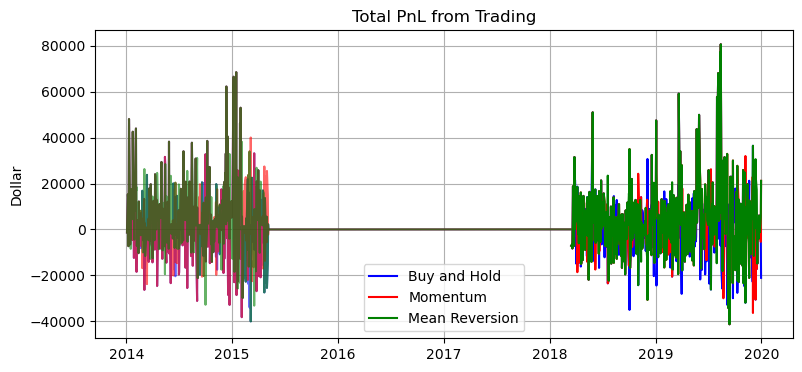

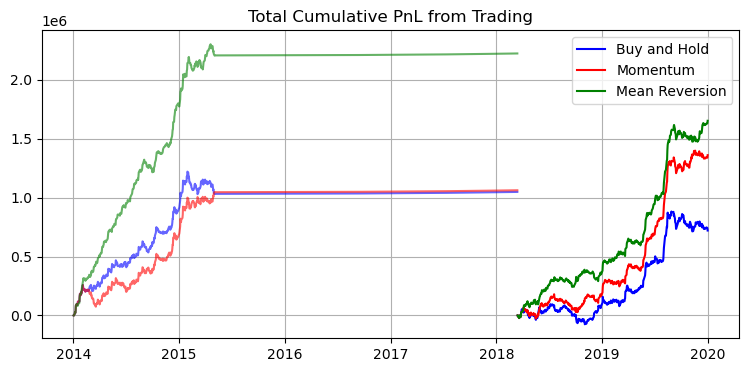

In [14]:
# plot the PnL of the three strategies
plt.figure(figsize=(9, 4))
plt.plot(bh_train.get_PnL(), color='b', alpha=0.6)
plt.plot(bh_test.get_PnL(), label='Buy and Hold', color='b')
plt.plot(ma_train.get_PnL(), color='r', alpha=0.6)
plt.plot(ma_test.get_PnL(), label='Momentum', color='r')
plt.plot(mr_train.get_PnL(), color='g', alpha=0.6)
plt.plot(mr_test.get_PnL(), label='Mean Reversion', color='g')

plt.title('PnL from Trading')
plt.ylabel('Dollar')
plt.legend()
plt.grid()
plt.show()

# plot the cumulative PnL of the three strategies
plt.figure(figsize=(9, 4))
plt.plot(bh_train.get_cumulative_PnL(), color='b', alpha=0.6)
plt.plot(bh_test.get_cumulative_PnL() , label='Buy and Hold', color='b')
plt.plot(ma_train.get_cumulative_PnL(), color='r', alpha=0.6)
plt.plot(ma_test.get_cumulative_PnL(), label='Momentum', color='r')
plt.plot(mr_train.get_cumulative_PnL(), color='g', alpha=0.6)
plt.plot(mr_test.get_cumulative_PnL(), label='Mean Reversion', color='g')

plt.title('Cumulative PnL from Trading')
plt.legend()
plt.grid()
plt.show()

# plot the delta_cap_V of the three strategies
plt.figure(figsize=(9, 4))
plt.plot(bh_train.get_delta_cap_V(), color='b', alpha=0.6)
plt.plot(bh_test.get_delta_cap_V(), label='Buy and Hold', color='b')
plt.plot(ma_train.get_delta_cap_V(), color='r', alpha=0.6)
plt.plot(ma_test.get_delta_cap_V(), label='Momentum', color='r')
plt.plot(mr_train.get_delta_cap_V(), color='g', alpha=0.6)
plt.plot(mr_test.get_delta_cap_V(), label='Mean Reversion', color='g')

plt.title('Delta Cap V from Trading')
plt.ylabel('Dollar')
plt.legend()
plt.grid()
plt.show()

# plot the cumulative_cap_V of the three strategies
plt.figure(figsize=(9, 4))
plt.plot(bh_train.get_cumulative_cap_V(), color='b', alpha=0.6)
plt.plot(bh_test.get_cumulative_cap_V(), label='Buy and Hold', color='b')
plt.plot(ma_train.get_cumulative_cap_V(), color='r', alpha=0.6)
plt.plot(ma_test.get_cumulative_cap_V(), label='Momentum', color='r')
plt.plot(mr_train.get_cumulative_cap_V(), color='g', alpha=0.6)
plt.plot(mr_test.get_cumulative_cap_V(), label='Mean Reversion', color='g')

plt.title('Cumulative Cap V from Trading')
plt.legend()
plt.grid()
plt.show()

# plot PnL + delta_cap_V of the three strategies
plt.figure(figsize=(9, 4))
plt.plot(bh_train.get_PnL() + bh_train.get_delta_cap_V(), color='b', alpha=0.6)
plt.plot(bh_test.get_PnL() + bh_test.get_delta_cap_V(), label='Buy and Hold', color='b')
plt.plot(ma_train.get_PnL() + ma_train.get_delta_cap_V(), color='r', alpha=0.6)
plt.plot(ma_test.get_PnL() + ma_test.get_delta_cap_V(), label='Momentum', color='r')
plt.plot(mr_train.get_PnL() + mr_train.get_delta_cap_V(), color='g', alpha=0.6)
plt.plot(mr_test.get_PnL() + mr_test.get_delta_cap_V(), label='Mean Reversion', color='g')

plt.title('Total PnL from Trading')
plt.ylabel('Dollar')
plt.legend()
plt.grid()
plt.show()

# plot the cumulative PnL + cumulative_cap_V of the three strategies
plt.figure(figsize=(9, 4))
plt.plot(bh_train.get_cumulative_PnL() + bh_train.get_cumulative_cap_V(), color='b', alpha=0.6)
plt.plot(bh_test.get_cumulative_PnL() + bh_test.get_cumulative_cap_V(), label='Buy and Hold', color='b')
plt.plot(ma_train.get_cumulative_PnL() + ma_train.get_cumulative_cap_V(), color='r', alpha=0.6)
plt.plot(ma_test.get_cumulative_PnL() + ma_test.get_cumulative_cap_V(), label='Momentum', color='r')
plt.plot(mr_train.get_cumulative_PnL() + mr_train.get_cumulative_cap_V(), color='g', alpha=0.6)
plt.plot(mr_test.get_cumulative_PnL() + mr_test.get_cumulative_cap_V(), label='Mean Reversion', color='g')

plt.title('Total Cumulative PnL from Trading')
plt.legend()
plt.grid()
plt.show()

## Performance Indicators

In [15]:
# get the Sharpe Ratio of the three strategies
def sharpe_ratio(excess_returns):
    sharpe = ((np.mean(excess_returns * 252)) / (np.std(excess_returns)*np.sqrt(252)))
    return sharpe

def sortino_ratio(excess_returns):
    sorties = ((np.mean(excess_returns * 252)) / (np.std(excess_returns[excess_returns < 0])*np.sqrt(252)))
    return sorties

In [16]:
bh_train_excess_returns = (bh_train.get_PnL() + bh_train.get_delta_cap_V())[1:]
TRAIN_sharpe_bh = sharpe_ratio(bh_train_excess_returns)
TRAIN_sortino_bh = sortino_ratio(bh_train_excess_returns)

bh_test_excess_returns = (bh_test.get_PnL() + bh_test.get_delta_cap_V())[1:]
TEST_sharpe_bh = sharpe_ratio(bh_test_excess_returns)
TEST_sortino_bh = sortino_ratio(bh_test_excess_returns)

ma_train_excess_returns = (ma_train.get_PnL() + ma_train.get_delta_cap_V())[1:]
TRAIN_sharpe_ma = sharpe_ratio(ma_train_excess_returns)
TRAIN_sortino_ma = sortino_ratio(ma_train_excess_returns)

ma_test_excess_returns = (ma_test.get_PnL() + ma_test.get_delta_cap_V())[1:]
TEST_sharpe_ma = sharpe_ratio(ma_test_excess_returns)
TEST_sortino_ma = sortino_ratio(ma_test_excess_returns)

mr_train_excess_returns = (mr_train.get_PnL() + mr_train.get_delta_cap_V())[1:]
TRAIN_sharpe_mr = sharpe_ratio(mr_train_excess_returns)
TRAIN_sortino_mr = sortino_ratio(mr_train_excess_returns)

mr_test_excess_returns = (mr_test.get_PnL() + mr_test.get_delta_cap_V())[1:]
TEST_sharpe_mr = sharpe_ratio(mr_test_excess_returns)
TEST_sortino_mr = sortino_ratio(mr_test_excess_returns)

print("Buy and Hold Train Sharpe Ratio: {}; Buy and Hold Train Sortino Ratio: {}".format(TRAIN_sharpe_bh, TRAIN_sortino_bh))
print("Buy and Hold Test Sharpe Ratio: {}; Buy and Hold Test Sortino Ratio: {}".format(TEST_sharpe_bh, TEST_sortino_bh))
print("Momentum Train Sharpe Ratio: {}; Momentum Train Sortino Ratio: {}".format(TRAIN_sharpe_ma, TRAIN_sortino_ma))
print("Momentum Test Sharpe Ratio: {}; Momentum Test Sortino Ratio: {}".format(TEST_sharpe_ma, TEST_sortino_ma))
print("Mean Reversion Train Sharpe Ratio: {}; Mean Reversion Train Sortino Ratio: {}".format(TRAIN_sharpe_mr, TRAIN_sortino_mr))
print("Mean Reversion Test Sharpe Ratio: {}; Mean Reversion Test Sortino Ratio: {}".format(TEST_sharpe_mr, TEST_sortino_mr))

Buy and Hold Train Sharpe Ratio: 1.6231502414390393; Buy and Hold Train Sortino Ratio: 1.785685124420698
Buy and Hold Test Sharpe Ratio: 1.6628321782789006; Buy and Hold Test Sortino Ratio: 3.1239524746855354
Momentum Train Sharpe Ratio: 1.6451212805334428; Momentum Train Sortino Ratio: 2.017433093664871
Momentum Test Sharpe Ratio: 3.1889628538588073; Momentum Test Sortino Ratio: 6.525705717271448
Mean Reversion Train Sharpe Ratio: 3.5190940124548433; Mean Reversion Train Sortino Ratio: 4.127455476058716
Mean Reversion Test Sharpe Ratio: 3.9102779316761946; Mean Reversion Test Sortino Ratio: 7.866527808086478


In [17]:
def max_drawdown(returns):
    running_max = np.maximum.accumulate(returns)
    drawdowns = 1 - returns / running_max
    return -np.max(drawdowns)

TRAIN_max_drawdown_bh = max_drawdown(np.cumsum(bh_train_excess_returns[1:]))
TEST_max_drawdown_bh = max_drawdown(np.cumsum(bh_test_excess_returns[:]))
TRAIN_max_drawdown_ma = max_drawdown(np.cumsum(ma_train_excess_returns[1:]))
TEST_max_drawdown_ma = max_drawdown(np.cumsum(ma_test_excess_returns[1:]))
TRAIN_max_drawdown_mr = max_drawdown(np.cumsum(mr_train_excess_returns[1:]))
TEST_max_drawdown_mr = max_drawdown(np.cumsum(mr_test_excess_returns[1:]))

print("Buy and Hold Train Max Drawdown: {}; Buy and Hold Test Max Drawdown: {}".format(TRAIN_max_drawdown_bh, TEST_max_drawdown_bh))
print("Momentum Train Max Drawdown: {}; Momentum Test Max Drawdown: {}".format(TRAIN_max_drawdown_ma, TEST_max_drawdown_ma))
print("Mean Reversion Train Max Drawdown: {}; Mean Reversion Test Max Drawdown: {}".format(TRAIN_max_drawdown_mr, TEST_max_drawdown_mr))



Buy and Hold Train Max Drawdown: -0.2549439308856053; Buy and Hold Test Max Drawdown: -1.780216203994978
Momentum Train Max Drawdown: -0.7079103714176465; Momentum Test Max Drawdown: -1.4564824427050729
Mean Reversion Train Max Drawdown: -0.2549439308856053; Mean Reversion Test Max Drawdown: -1.4564824427050729


In [18]:
def calmar_ratio(returns, max_drawdown):
    calmar = (np.mean(returns) * 252) / abs(max_drawdown)
    return calmar

TRAIN_calmar_bh = calmar_ratio(bh_train_excess_returns[1:] / np.cumsum(bh_train_excess_returns[1:]), TRAIN_max_drawdown_bh)
TEST_calmar_bh = calmar_ratio(bh_test_excess_returns[1:] / np.cumsum(bh_test_excess_returns[1:]), TEST_max_drawdown_bh)
TRAIN_calmar_ma = calmar_ratio(ma_train_excess_returns[1:] / np.cumsum(ma_train_excess_returns[1:]), TRAIN_max_drawdown_ma)
TEST_calmar_ma = calmar_ratio(ma_test_excess_returns[1:] / np.cumsum(ma_test_excess_returns[1:]), TEST_max_drawdown_ma)
TRAIN_calmar_mr = calmar_ratio(mr_train_excess_returns[1:] / np.cumsum(mr_train_excess_returns[1:]), TRAIN_max_drawdown_mr)
TEST_calmar_mr = calmar_ratio(mr_test_excess_returns[1:] / np.cumsum(mr_test_excess_returns[1:]), TEST_max_drawdown_mr)

print("Buy and Hold Train Calmar Ratio: {}; Buy and Hold Test Calmar Ratio: {}".format(TRAIN_calmar_bh, TEST_calmar_bh))
print("Momentum Train Calmar Ratio: {}; Momentum Test Calmar Ratio: {}".format(TRAIN_calmar_ma, TEST_calmar_ma))
print("Mean Reversion Train Calmar Ratio: {}; Mean Reversion Test Calmar Ratio: {}".format(TRAIN_calmar_mr, TEST_calmar_mr))

Buy and Hold Train Calmar Ratio: 4.083281385798163; Buy and Hold Test Calmar Ratio: 1.3759204430236034
Momentum Train Calmar Ratio: 1.3828354179153417; Momentum Test Calmar Ratio: -1.14419578530782
Mean Reversion Train Calmar Ratio: 4.874990375118535; Mean Reversion Test Calmar Ratio: 4.27026282847823


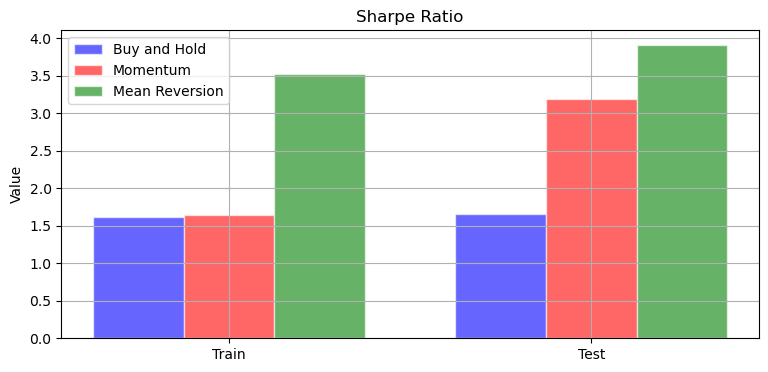

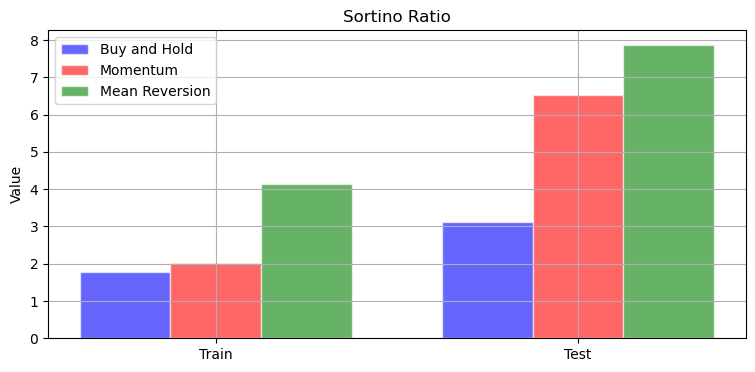

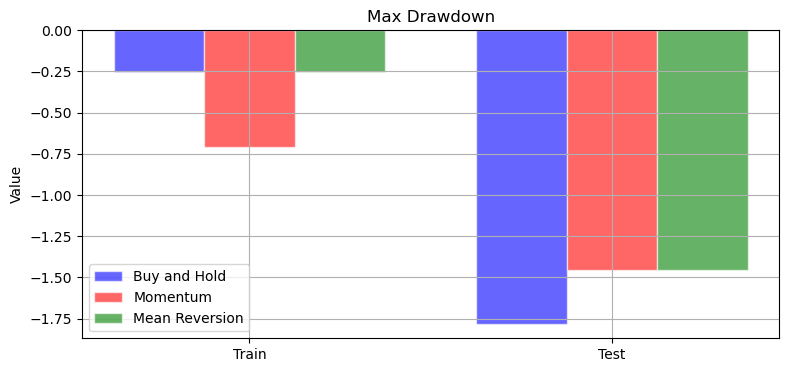

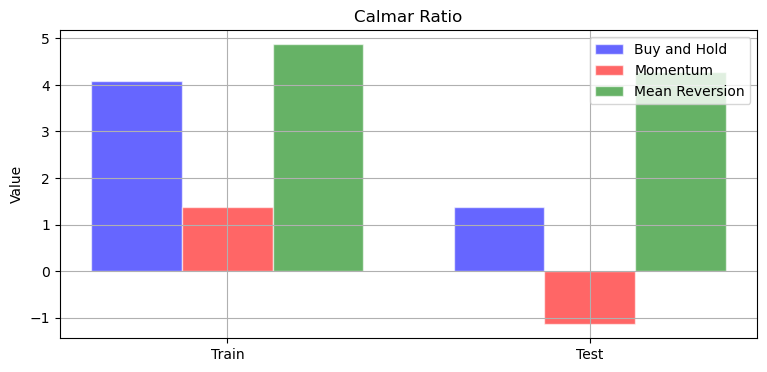

In [19]:
# plot the sharpe ratio of the three strategies using bar chart
bar_width = 0.25

br1 = np.arange(len([TRAIN_sharpe_bh, TEST_sharpe_bh]))
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]

bh_sharpe = [TRAIN_sharpe_bh, TEST_sharpe_bh]
ma_sharpe = [TRAIN_sharpe_ma, TEST_sharpe_ma]
mr_sharpe = [TRAIN_sharpe_mr, TEST_sharpe_mr]

bh_sortino = [TRAIN_sortino_bh, TEST_sortino_bh]
ma_sortino = [TRAIN_sortino_ma, TEST_sortino_ma]
mr_sortino = [TRAIN_sortino_mr, TEST_sortino_mr]

bh_max_drawdown = [TRAIN_max_drawdown_bh, TEST_max_drawdown_bh]
ma_max_drawdown = [TRAIN_max_drawdown_ma, TEST_max_drawdown_ma]
mr_max_drawdown = [TRAIN_max_drawdown_mr, TEST_max_drawdown_mr]

bh_calmar = [TRAIN_calmar_bh, TEST_calmar_bh]
ma_calmar = [TRAIN_calmar_ma, TEST_calmar_ma]
mr_calmar = [TRAIN_calmar_mr, TEST_calmar_mr]


plt.figure(figsize=(9, 4))
plt.bar(br1, bh_sharpe, color='b', width=bar_width, edgecolor='white', label='Buy and Hold', alpha=0.6)
plt.bar(br2, ma_sharpe, color='r', width=bar_width, edgecolor='white', label='Momentum', alpha=0.6)
plt.bar(br3, mr_sharpe, color='g', width=bar_width, edgecolor='white', label='Mean Reversion', alpha=0.6)
plt.xticks([r + bar_width for r in range(len([TRAIN_sharpe_bh, TEST_sharpe_bh]))], ['Train', 'Test'])
plt.title('Sharpe Ratio')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(9, 4))
plt.bar(br1, bh_sortino, color='b', width=bar_width, edgecolor='white', label='Buy and Hold', alpha=0.6)
plt.bar(br2, ma_sortino, color='r', width=bar_width, edgecolor='white', label='Momentum', alpha=0.6)
plt.bar(br3, mr_sortino, color='g', width=bar_width, edgecolor='white', label='Mean Reversion', alpha=0.6)
plt.xticks([r + bar_width for r in range(len([TRAIN_sortino_bh, TEST_sortino_bh]))], ['Train', 'Test'])
plt.title('Sortino Ratio')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(9, 4))
plt.bar(br1, bh_max_drawdown, color='b', width=bar_width, edgecolor='white', label='Buy and Hold', alpha=0.6)
plt.bar(br2, ma_max_drawdown, color='r', width=bar_width, edgecolor='white', label='Momentum', alpha=0.6)
plt.bar(br3, mr_max_drawdown, color='g', width=bar_width, edgecolor='white', label='Mean Reversion', alpha=0.6)
plt.xticks([r + bar_width for r in range(len([TRAIN_max_drawdown_bh, TEST_max_drawdown_bh]))], ['Train', 'Test'])
plt.title('Max Drawdown')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(9, 4))
plt.bar(br1, bh_calmar, color='b', width=bar_width, edgecolor='white', label='Buy and Hold', alpha=0.6)
plt.bar(br2, ma_calmar, color='r', width=bar_width, edgecolor='white', label='Momentum', alpha=0.6)
plt.bar(br3, mr_calmar, color='g', width=bar_width, edgecolor='white', label='Mean Reversion', alpha=0.6)
plt.xticks([r + bar_width for r in range(len([TRAIN_calmar_bh, TEST_calmar_bh]))], ['Train', 'Test'])
plt.title('Calmar Ratio')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


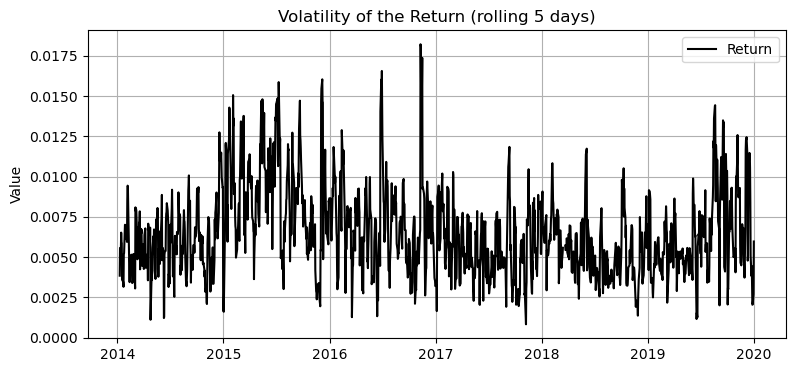

In [20]:
# plot the volatility of the price
plt.figure(figsize=(9, 4))
plt.plot(df['Return/Unit'].rolling(5).std(), label='Return', color='black')
plt.title('Volatility of the Return (rolling 5 days)')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 1.0, 'Drawdown of Buy and Hold Strategy and Volatility')

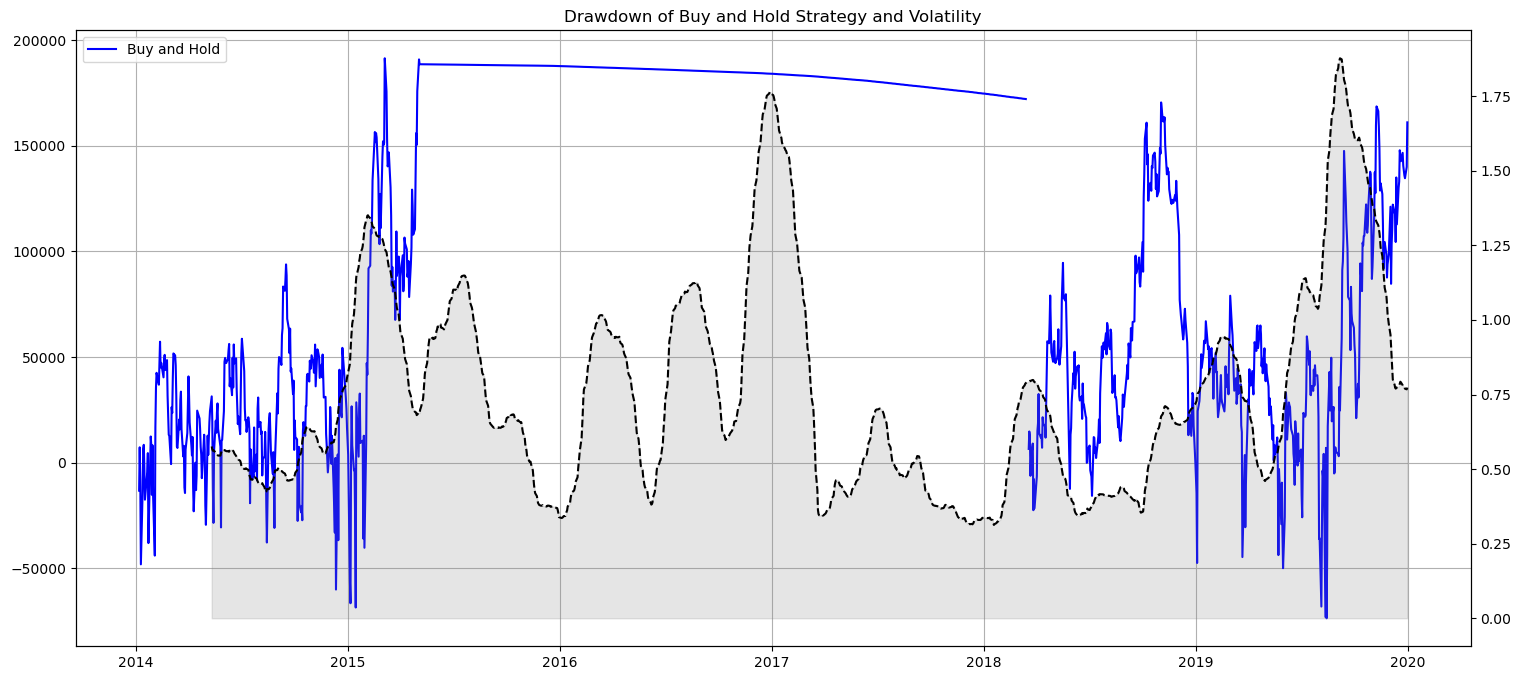

In [45]:
volatility = df['Adj Close'].rolling(90).std()

DD_bh_train = []
DD_bh_test = []

bh_train_excess_total = np.cumsum(bh_train_excess_returns[1:])
bh_test_excess_total = np.cumsum(bh_test_excess_returns[:])
for i in range(1, len(bh_train_excess_total)):
    DD_bh_train.append(max(bh_train_excess_total[:i]) - bh_train_excess_total[i])
for i in range(1, len(bh_test_excess_total)):
    DD_bh_test.append(max(bh_test_excess_total[:i]) - bh_test_excess_total[i])

# merge DD_bh_train and DD_bh_test to volatility
DD_bh_train = pd.Series(DD_bh_train, index=bh_train_excess_returns.index[2:])
DD_bh_test = pd.Series(DD_bh_test, index=bh_test_excess_returns.index[1:])
DD_bh_train = DD_bh_train.reindex(df.index)
DD_bh_test = DD_bh_test.reindex(df.index)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(DD_bh_train, label='Buy and Hold', color='b')
ax.plot(DD_bh_test, color='b')
ax_vol = ax.twinx()
ax_vol.plot(volatility, label='Volatility', color='black', linestyle='--')
ax_vol.fill_between(volatility.index, 0, volatility, color='gray', alpha=0.2)
ax.set_title('Drawdown of Buy and Hold Strategy')
ax.grid()
ax.legend(loc='upper left')
ax.set_title('Drawdown of Buy and Hold Strategy and Volatility')


Text(0.5, 1.0, 'Drawdown of Momentum Strategy and Volatility')

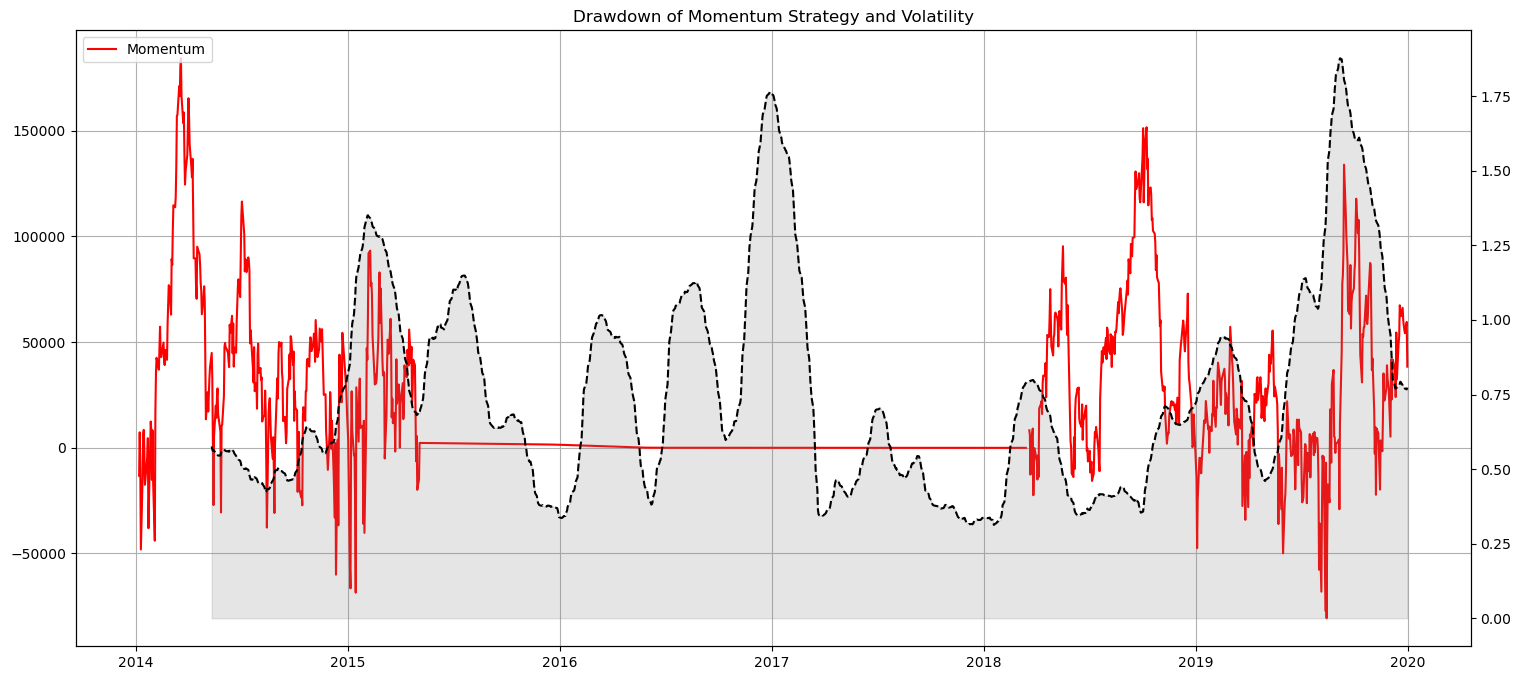

In [46]:
DD_ma_train = []
DD_ma_test = []

ma_train_excess_total = np.cumsum(ma_train_excess_returns[1:])
ma_test_excess_total = np.cumsum(ma_test_excess_returns[1:])

for i in range(1, len(ma_train_excess_total)):
    DD_ma_train.append(max(ma_train_excess_total[:i]) - ma_train_excess_total[i])
for i in range(1, len(ma_test_excess_total)):
    DD_ma_test.append(max(ma_test_excess_total[:i]) - ma_test_excess_total[i])

# merge DD_ma_train and DD_ma_test to volatility
DD_ma_train = pd.Series(DD_ma_train, index=ma_train_excess_returns.index[2:])
DD_ma_test = pd.Series(DD_ma_test, index=ma_test_excess_returns.index[2:])
DD_ma_train = DD_ma_train.reindex(df.index)
DD_ma_test = DD_ma_test.reindex(df.index)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(DD_ma_train, label='Momentum', color='r')
ax.plot(DD_ma_test, color='r')
ax_vol = ax.twinx()
ax_vol.plot(volatility, label='Volatility', color='black', linestyle='--')
ax_vol.fill_between(volatility.index, 0, volatility, color='gray', alpha=0.2)
ax.set_title('Drawdown of Momentum Strategy')
ax.grid()
ax.legend(loc='upper left')
ax.set_title('Drawdown of Momentum Strategy and Volatility')


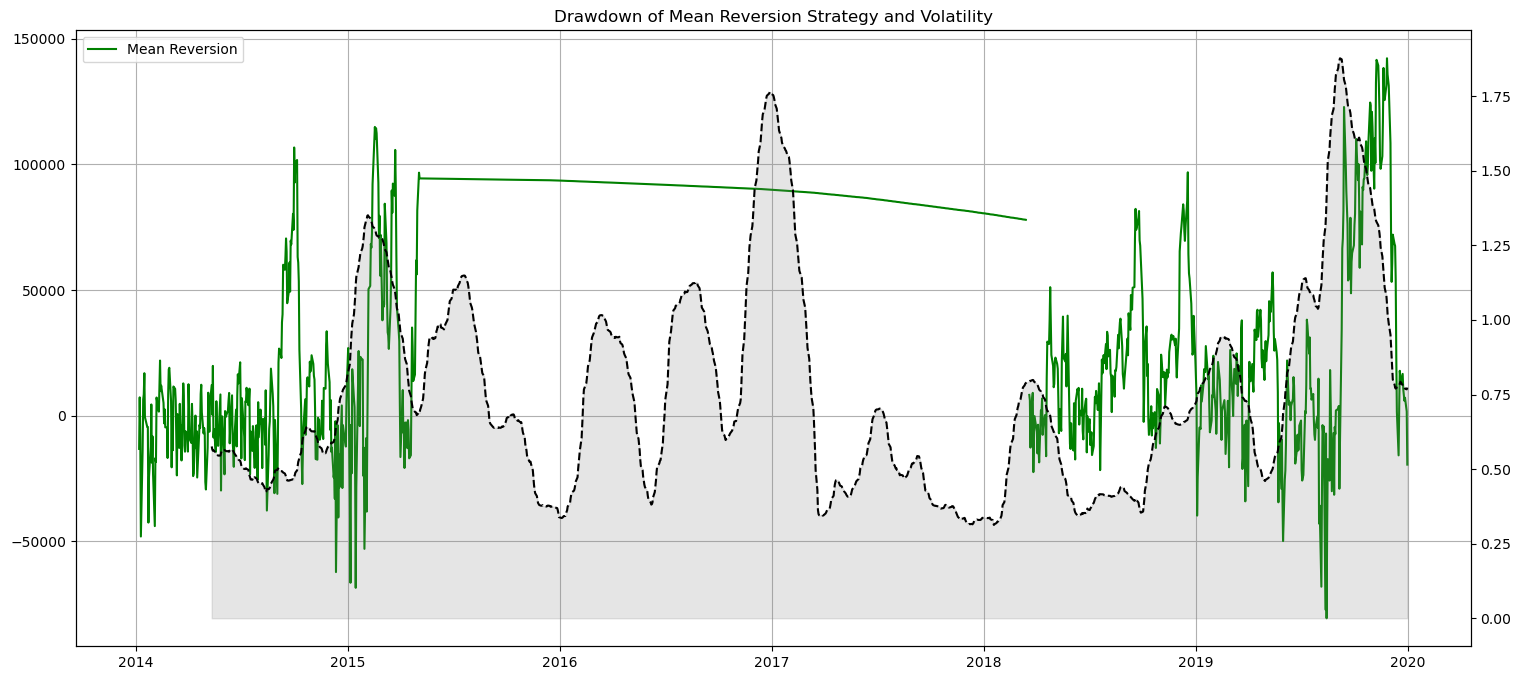

In [47]:
DD_mr_train = []
DD_mr_test = []

mr_train_excess_total = np.cumsum(mr_train_excess_returns[1:])
mr_test_excess_total = np.cumsum(mr_test_excess_returns[1:])

for i in range(1, len(mr_train_excess_total)):
    DD_mr_train.append(max(mr_train_excess_total[:i]) - mr_train_excess_total[i])
for i in range(1, len(mr_test_excess_total)):
    DD_mr_test.append(max(mr_test_excess_total[:i]) - mr_test_excess_total[i])

# merge DD_mr_train and DD_mr_test to volatility
DD_mr_train = pd.Series(DD_mr_train, index=mr_train_excess_returns.index[2:])
DD_mr_test = pd.Series(DD_mr_test, index=mr_test_excess_returns.index[2:])
DD_mr_train = DD_mr_train.reindex(df.index)
DD_mr_test = DD_mr_test.reindex(df.index)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(DD_mr_train, label='Mean Reversion', color='g')
ax.plot(DD_mr_test, color='g')
ax_vol = ax.twinx()
ax_vol.plot(volatility, label='Volatility', color='black', linestyle='--')
ax_vol.fill_between(volatility.index, 0, volatility, color='gray', alpha=0.2)
ax.set_title('Drawdown of Mean Reversion Strategy')
ax.grid()
ax.legend(loc='upper left')
ax.set_title('Drawdown of Mean Reversion Strategy and Volatility')
plt.show()